In [2]:
import pandas as pd
from datetime import datetime as dt

date_time_format = '%Y/%m/%d %H:%M:%S'
df = pd.read_csv('connection_2019.csv', delimiter = ';')
def preprocess(data):
#     data = pd.read_csv(filename, sep = delimiter)
    data['EVENT_PURPOSE'] = data['EVENT_C'] + '_' + data['DERIVED_CNTR_PURP_C']
    
    # data["BTR1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.BTR1]
    data["ATD1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATD1]
    # data["ATU1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATU1]
    # data["BTR2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.BTR2]
    # data["ATD2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATD2]
    # data["ATU2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATU2]
    
    data['DIFF_ATD1_BTR1'] = [(dt.strptime(row['ATD1'], date_time_format) - dt.strptime(row['BTR1'], date_time_format)).total_seconds() / 60 \
                          for index, row in data.iterrows()]
    data['DIFF_ATU1_ATD1'] = [(dt.strptime(row['ATU1'], date_time_format) - dt.strptime(row['ATD1'], date_time_format)).total_seconds() / 60 \
                              for index, row in data.iterrows()]
    #data['DIFF_ATD2_BTR2'] = [(dt.strptime(row['ATD2'], date_time_format) - dt.strptime(row['BTR2'], date_time_format)).total_seconds() / 60 \
    #                          for index, row in data.iterrows() if not pd.isna(row['BTR2']) and not pd.isna(row['ATD2'])]
    #data['DIFF_ATU2_ATD2'] = [(dt.strptime(row['ATU2'], date_time_format) - dt.strptime(row['ATD2'], date_time_format)).total_seconds() / 60 \
    #                          for index, row in data.iterrows() if not pd.isna(row['ATU2']) and not pd.isna(row['ATD2'])]
    
    #data['DIFF_ATU2_ATD1'] = [(dt.strptime(row['ATU2'], date_time_format) - dt.strptime(row['ATD1'], date_time_format)).total_seconds() / 60 \
    #                      for index, row in data.iterrows() if not pd.isna(row['ATU2'])]
    
    data = data.drop(columns = ['EVENT_C', 'ABBR_VESSEL_M1', 'BTR1', 'ATD1', 'ATU1', 'SERVICE_TYPE_DESC_X1', \
                            'CONSORTIUM_C1', 'ABBR_VESSEL_M2', 'BTR2', 'ATD2', 'ATU2', 'SERVICE_TYPE_DESC_X2', \
                            'CONSORTIUM_C2', 'OPR_GROUP_C', 'SUMOFBOX_Q'])
    return data
df = preprocess(df)

In [2]:
df = pd.read_csv('connection_2019_preprocessed.csv')

In [3]:
df.to_csv('connection_2019_preprocessed.csv', index=False)

In [4]:
df.columns

Index(['CNTR_STATUS_C', 'DISC_PORT1_C', 'LOAD_PORT_C', 'LINE_C1_GROUP',
       'SERVICE_C1', 'DIRECTION_C1', 'CAPACITY1', 'LINE_C2_GROUP',
       'SERVICE_C2', 'DIRECTION_C2', 'CAPACITY2', 'DERIVED_CNTR_PURP_C',
       'SUMOFTEU_Q', 'EVENT_PURPOSE', 'ATD1_DATE', 'DIFF_ATD1_BTR1',
       'DIFF_ATU1_ATD1'],
      dtype='object')

In [52]:
df.EVENT_PURPOSE.unique()

array(['DISC_IMPT', 'DISC_TSHIP', 'DISC_LRSHP', 'DISC_REXPT', 'LOAD_EXPT',
       'LOAD_TSHIP', 'LOAD_LRSHP', 'LOAD_REXPT'], dtype=object)

In [54]:
tship1 = df[df['EVENT_PURPOSE'] == 'LOAD_TSHIP']
tship2 = df[df['EVENT_PURPOSE'] == 'DISC_TSHIP']
tship = pd.concat([tship1, tship2])
print(tship1.shape)
print(tship2.shape)
print(tship.shape)


tship_sorted = tship.sort_values(by = 'ATD1_DATE')

tship_sorted = tship_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2019-01-01', end = '2019-12-31')
string_date_rng = tship_sorted.index.tolist()

timestamp_date_tship = pd.to_datetime(string_date_rng, infer_datetime_format = True)
tship_sorted.index = timestamp_date_tship

teu_by_day_tship = tship_sorted['SUMOFTEU_Q'].resample('D').sum()

(1435693, 17)
(1431016, 17)
(2866709, 17)


In [5]:
lrshp = df[df['DERIVED_CNTR_PURP_C'] == 'LRSHP']

lrshp_sorted = lrshp.sort_values(by = 'ATD1_DATE')

lrshp_sorted = lrshp_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2017-01-01', end = '2017-12-31')
string_date_rng = lrshp_sorted.index.tolist()

timestamp_date_lrshp = pd.to_datetime(string_date_rng, infer_datetime_format = True)
lrshp_sorted.index = timestamp_date_lrshp

teu_by_day = lrshp_sorted['SUMOFTEU_Q'].resample('D').sum()

In [39]:
from matplotlib import pyplot as plt
# teu_by_day.plot()
# pyplot.show()

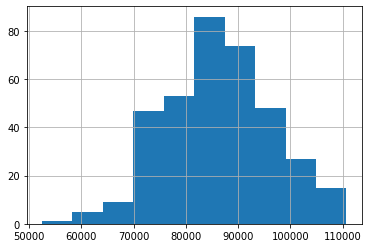

In [56]:
# distribution summary plot
teu_by_day_tship.hist()
pyplot.show()

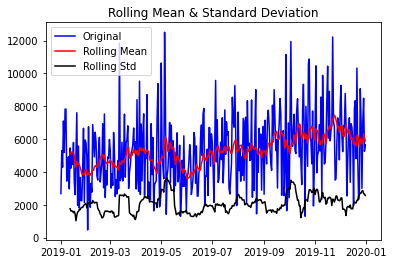

Results of Dickey-Fuller Test:
Test Statistic                  -2.262122
p-value                          0.184475
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


In [36]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue',label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label = 'Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(teu_by_day)

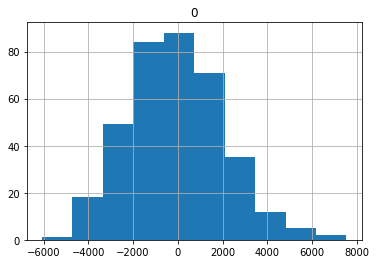

In [26]:
# residual distribution plot
residuals.hist()
pyplot.show()

In [55]:
#adfuller test for stationarity
#reference: https://machinelearningmastery.com/time-series-data-stationary-python/
from statsmodels.tsa.stattools import adfuller
result = adfuller(teu_by_day_tship)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.475398
p-value: 0.008642
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [27]:
result = adfuller(residuals)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.516851
p-value: 0.000183
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [37]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(teu_by_day, nlags=20)
lag_pacf = pacf(teu_by_day, nlags=20, method='ols')

In [41]:
import numpy as np

Text(0.5, 1.0, 'Autocorrelation Function')

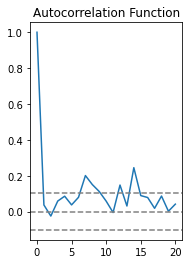

In [43]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(teu_by_day)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(teu_by_day)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

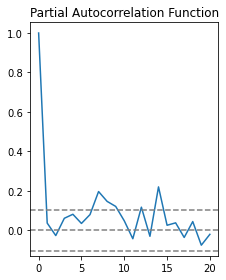

In [44]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(teu_by_day)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(teu_by_day)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 1708577496.9023')

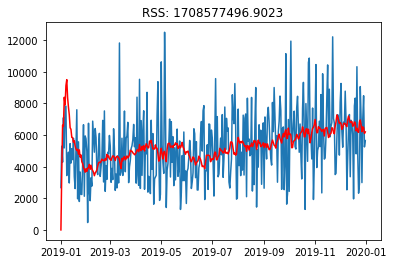

In [47]:
# reference: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
model = ARIMA(teu_by_day, order=(1,2,7))
results_ARIMA = model.fit()
plt.plot(teu_by_day)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-teu_by_day)**2))

conclusion: the lrshp for 2019 and residuals upon fitting the model is a stationary time series

Forecasting, reference: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

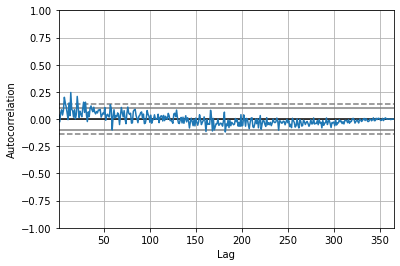

In [9]:
from pandas.plotting import autocorrelation_plot 
autocorrelation_plot(teu_by_day)
pyplot.show()

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = 99999999, None
    output = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        output.append((order, mse))
                        print('(BETTER) ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    print('evaluation failed')
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return output

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = range(0, 3)
q_values = [0,1,7,14,30]
modelperformances = evaluate_models(teu_by_day_tship, p_values, d_values, q_values)

                               SARIMAX Results                                
Dep. Variable:             SUMOFTEU_Q   No. Observations:                  365
Model:                 ARIMA(1, 0, 7)   Log Likelihood               -3873.895
Date:                Tue, 09 Mar 2021   AIC                           7767.790
Time:                        11:32:31   BIC                           7806.789
Sample:                    01-01-2019   HQIC                          7783.289
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.616e+04    644.780    133.625      0.000    8.49e+04    8.74e+04
ar.L1          0.0599      0.303      0.197      0.843      -0.535       0.655
ma.L1         -0.1388      0.300     -0.463      0.6

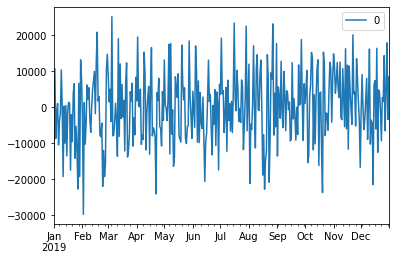

                  0
count    365.000000
mean      23.268335
std     9854.407317
min   -29733.347527
25%    -7031.767306
50%      519.572263
75%     6372.454272
max    25171.842366


In [64]:
# fit model
model = ARIMA(teu_by_day_p, order=(1,0,7))
model_fit = model.fit()tshi

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
# residuals.plot(kind='kde')
# pyplot.show()

# summary stats of residuals
print(residuals.describe())

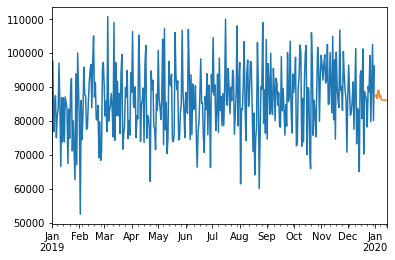

In [65]:
start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = model_fit.predict(start=start_index, end=end_index)

teu_by_day_tship.plot()
forecast.plot()
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:             SUMOFTEU_Q   No. Observations:                  365
Model:                 ARIMA(1, 2, 7)   Log Likelihood               -3302.115
Date:                Tue, 09 Mar 2021   AIC                           6622.230
Time:                        10:30:15   BIC                           6657.280
Sample:                    01-01-2019   HQIC                          6636.162
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.014    -69.662      0.000      -1.028      -0.972
ma.L1         -1.0686      0.047    -22.728      0.000      -1.161      -0.976
ma.L2         -1.0103      0.039    -26.125      0.0

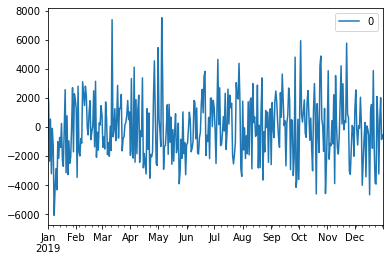

                 0
count   365.000000
mean    -48.624825
std    2165.992464
min   -6069.464507
25%   -1669.821601
50%     -48.443655
75%    1339.618332
max    7535.532571


In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(teu_by_day, order=(1,2,7))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
# residuals.plot(kind='kde')
# pyplot.show()

# summary stats of residuals
print(residuals.describe())

In [24]:
from datetime import datetime
start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = model_fit.predict(start=start_index, end=end_index)

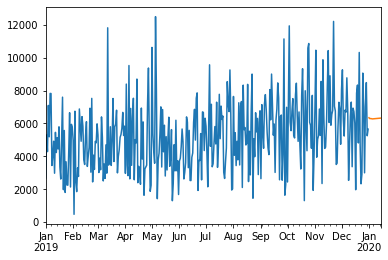

In [25]:
teu_by_day.plot()
forecast.plot()
pyplot.show()
